In [7]:
from Helpers import *
from Controller import *
#alacon

In [8]:
def Feedback_Linearization_modified(Duration,w1,w2,w3,w4,r1,r2,targets = [0,55],starting_point = [0,30],plot = True,Noise_Variance = 1e-6,ForceField = [0,0],ForceFieldSpan = [0,0],newtonfunc = f,newtondfunc = df,Num_iter = 600):
    
    """
    Duration (float) : Duration of the movement

    w1 (float) : Weight associated to the penalty on shoulder angle 
    
    w2 (float) : Weight associated to the penalty on elbow angle 

    w3 (float) : Weight associated to the penalty on shoulder angular velocity

    w4 (float) : Weight associated to the penalty on elbow angular velocity

    r1 (float) : Weight associated to the motor cost on shoulder torques

    r2 (float) : Weight associated to the motor cost on elbow torques

    targets (array of float of size 2): X,Y Position of the end point of the movement
        must be a biomechanically feasible end point considering that the shoulder is at (0,0)

    starting_point (array of float of size 2): X,Y Position of the starting point of the movement
        must be a biomechanically feasible starting point considering that the shoulder is at (0,0)
    
    plot (boolean) : Allowing plot outputs of the hand trajectory for the experiment

    Noise_Variance (float) : Gaussian variance associated to the white noise in the model

    ForceField (array of float of size 2) : Shoulder and Elbow Perturbations Torques applied during the movement 

    ForceFieldSpan (array of float of size 2) : The time span in seconds of the lateral forcefield (to the right)
    """

    dt = Duration/Num_iter 

    obj1,obj2 = newton(newtonfunc,newtondfunc,1e-8,1000,targets[0],targets[1]) #Defini les targets
    st1,st2 = newton(newtonfunc,newtondfunc,1e-8,1000,starting_point[0],starting_point[1])

    x0 = np.array([st1,0,0,st2,0,0,obj1,obj2])

    Num_Var = 8
    
    #Define Weight Matrices of the cost function
    R = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
               [0,0,0,w2,0,0,0,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
               [0-w1,0,0,0,0,0,w1,0],[0,0,0,-w2,0,0,0,w2]])

    
    
    #Define the Dynamic of the linear system 

    Kfactor = 1/0.06
    A = np.array([[1,dt,0,0,0,0,0,0],[0,1,dt,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,0,0,0,1,dt,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
    B = np.array([[0,0],[0,0],[dt,0],[0,0],[0,0],[0,dt],[0,0],[0,0]])
    
    
    #Compute the Feedback Gain of the Control law
    S = Q

    
    array_L = np.zeros((Num_iter-1,2,Num_Var))   
    array_S = np.zeros((Num_iter,Num_Var,Num_Var)) 
    array_S[-1] = Q
    for k in range(Num_iter-1):
        L = np.linalg.inv(R+B.T@S@B)@B.T@S@A
        array_L[Num_iter-2-k] = L
        S = A.T@S@(A-B@L)
        array_S[Num_iter-2-k] = S
        
    #Initialize matrices 

    sigma = np.identity(Num_Var)*10**-6 
    H,L = np.identity(8),array_L

    #Initialize the arrays to stock the simulations 
    array_xhat = np.zeros((Num_iter,Num_Var))
    array_u = np.zeros((Num_iter-1,2))
    array_x_nonlin = np.zeros((Num_iter,Num_Var-2)) 
    y = np.zeros((Num_iter,Num_Var))

    #Initialize the state vectors of the linear system
    array_xhat[0] = x0.flatten()
    xhat = np.copy(x0)
    x_true = np.copy(x0)

    #Initialize the state vectors of the nonlinear system
    x_nonlin = np.zeros(Num_Var-2)
    x_nonlin[0],x_nonlin[1] = x0[0],x0[3]

    new_x_nonlin = np.copy(x_nonlin)

    #Perform the task
    J = 0
    for k in range(Num_iter-1):

        #Compute the matrices of the system in function of the current state 

        F = ForceField if ((k*dt > ForceFieldSpan[0]) and (k*dt < ForceFieldSpan[1])) else 0
        
        Omega_sens,motor_noise,Omega_measure,measure_noise = Compute_Noise(Num_Var,Noise_Variance)
            
        C = np.array([-x_nonlin[3]*(2*x_nonlin[2]+x_nonlin[3])*a2*np.sin(x_nonlin[1]),x_nonlin[2]*x_nonlin[2]*a2*np.sin(x_nonlin[1])])
        Denominator = a3*(a1-a3)-a2*a2*np.cos(x_nonlin[1])*np.cos(x_nonlin[1])
        Minv = np.array([[a3/Denominator,(-a2*np.cos(x_nonlin[1])-a3)/Denominator],[(-a2*np.cos(x_nonlin[1])-a3)/Denominator,(2*a2*np.cos(x_nonlin[1])+a1)/Denominator]])
        
        xhat = x_true
        Denominator = a3*(a1-a3)-a2*a2*np.cos(xhat[3])*np.cos(xhat[3])
        M = np.array([[a1+2*a2*cos(xhat[3]),a3+a2*cos(xhat[3])],[a3+a2*cos(xhat[3]),a3]])
        Minvdot = np.array([[-a3*a2*a2*sin(2*xhat[3])*xhat[4]/(Denominator*Denominator),
                             (a2*sin(xhat[3])*xhat[4]*Denominator+(a2*cos(xhat[3])+a3)*a2*a2*sin(2*xhat[3])*xhat[4])/(Denominator*Denominator)],
                            [(a2*sin(xhat[3])*xhat[4]*Denominator+(a2*cos(xhat[3])+a3)*a2*a2*sin(2*xhat[3])*xhat[4])/(Denominator*Denominator),
                            (-2*a2*sin(xhat[3])*xhat[4]*Denominator-(2*a2*cos(xhat[3])+a1)*a2*a2*sin(2*xhat[3])*xhat[4])/(Denominator*Denominator)]])
            
        Cdot = np.array([-a2*xhat[5]*(2*xhat[1]+xhat[4])*sin(xhat[3])-a2*xhat[4]*(2*xhat[2]+xhat[5])*sin(xhat[3])
                         -a2*xhat[4]*xhat[4]*(2*xhat[1]+xhat[4])*cos(xhat[3]),2*xhat[1]*xhat[2]*a2*sin(xhat[3])+xhat[1]*xhat[1]*a2*cos(xhat[3])*xhat[4]])
        
        COLORS = "red"
        LABEL = "Feedback Linearization"


        # Compute the command 

        v = -L[k].reshape(np.flip(B.shape))@xhat
        u = 1/Kfactor*M@(v)-1/Kfactor*M@Minvdot@M@(np.array([xhat[2],xhat[5]]))+M@(np.array([xhat[2],xhat[5]]))+C+Bdyn@np.array([xhat[1],xhat[4]])+1/Kfactor*Cdot+1/Kfactor*Bdyn@np.array([xhat[2],xhat[5]])
        array_u[k] = u
        J+= u.T@R@u
        # True state of the system
        new_x_nonlin[0:2] += dt*x_nonlin[2:4]
        new_x_nonlin[2:4] += dt*(Minv@(x_nonlin[4:6]-Bdyn@(x_nonlin[2:4])-C))  
        new_x_nonlin[4:6] += dt*Kfactor*(u-x_nonlin[4:6]+F)

            
        acc = (Minv@(x_nonlin[4:6]-Bdyn@(x_nonlin[2:4])-C)) 
        x_true = np.array([new_x_nonlin[0],new_x_nonlin[2],acc[0],new_x_nonlin[1],new_x_nonlin[3],acc[1],x_true[6],x_true[7]]) + motor_noise
        
        y[k] = y[k] = (H@x_true+measure_noise).flatten()
        #Change of variable 
        

        #Perform Iteration 
        
        K = A@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_sens + (A - K@H)@sigma@A.T
        #print(y[k]-H@x_internalmodel)
        xhat = A@xhat+B@v + K@(y[k]-H@xhat)

        
        x_nonlin = np.copy(new_x_nonlin)
        array_xhat[k+1] = xhat.flatten()
        array_x_nonlin[k+1] = new_x_nonlin.flatten()
        #print(array_x_true[k-1,2],((array_x_true[k]-array_x_true[k-1])/dt)[1])   

    #Change of coordinates from angular to cartesian 
    #J+= x_true.T@Q@x_true
    print("Total cost of FL: "+str(J)[:7])
    x_nonlin = array_xhat.T[:,1:][:,::1]
    X = np.cos(x_nonlin[0]+x_nonlin[3])*33+np.cos(x_nonlin[0])*30
    Y = np.sin(x_nonlin[0]+x_nonlin[3])*33+np.sin(x_nonlin[0])*30

    #Plotting
    if plot : 
        plt.grid(linestyle='--')
        plt.axis("equal")
        plt.plot(X,Y,color = COLORS,label = LABEL,linewidth = .8)
        plt.xlabel("X [cm]")
        plt.ylabel("Y [cm]")
        plt.scatter([starting_point[0],targets[0]],[starting_point[1],targets[1]],color = "black")
    #print("Optimum values " + str(J1)[:8]+" and "+str(J2)[:8])

    
    return X,Y,array_u

Total cost ILQG: 5.147047350953274
Total cost of LQG : 1529134
Total cost of FL: 4.74053
Total cost ILQG: 3.874956799816014
Total cost of LQG : 2611207
Total cost of FL: 3.52705
Total cost ILQG: 4.124049279434198
Total cost of LQG : 3449186
Total cost of FL: 3.61942
Total cost ILQG: 6.997365071084705
Total cost of LQG : 3532442
Total cost of FL: 6.16510
Total cost ILQG: 2.1669144771161553
Total cost of LQG : 1950657
Total cost of FL: 2.09912
Total cost ILQG: 8.550091481008586
Total cost of LQG : 715141.
Total cost of FL: 7.55114
Total cost ILQG: 3.4655187043215916
Total cost of LQG : 566238.
Total cost of FL: 2.94247
Total cost ILQG: 8.01498554453419
Total cost of LQG : 8703294
Total cost of FL: 7.48310


<Figure size 2000x2000 with 0 Axes>

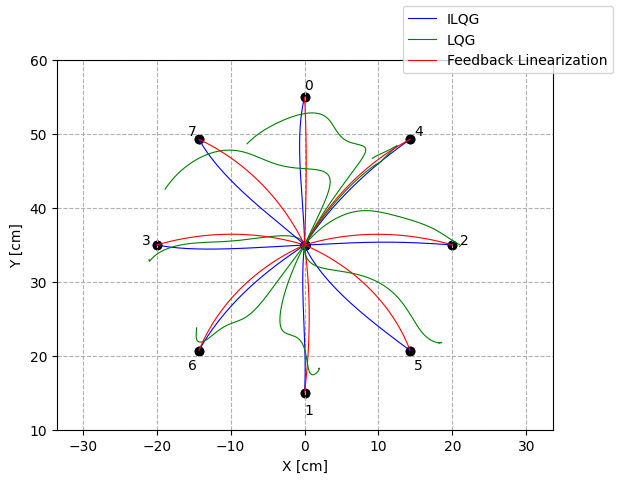

In [9]:
K = 2000
Duration = .5
fig = plt.figure(figsize=(20,20))
w1 = 1e7
w2 = 1e4
r1 = 1e-3
d = 14.285
start = [0,35]
fig,ax = plt.subplots()
TARG = [[0,55],[0,15],[20,35],[-20,35],[d,35+d],[d,35-d],[-d,35-d],[-d,35+d]]
TEXTE = [[0,56],[0,12],[21,35],[-22,35],[d+.5,35+d+.5],[d+.5,35-d-2.5],[-d-1.5,35-d-2.5],[-d-1.5,35+d+.5]]
for i in range(8):
    targets = TARG[i]
    plt.text(TEXTE[i][0],TEXTE[i][1],str(i))
    xILQG,yILQG,uILQG = ILQG(Duration,w1,w2,r1,targets,K,start)
    J = 0
    R = np.array([[r1,0],[0,r1]])
    for j in range(K-1):
        J+= uILQG[j].T@R@uILQG[j]

    print("Total cost ILQG: "+str(J))   

        
    X,Y = LQG(Duration,w1,w1,w2,w2,r1,r1,targets,start,Noise_Variance=1e-16,newtonfunc = fnewton,newtondfunc = dfnewton,Num_iter = K)
    X,Y,u = Feedback_Linearization_modified(Duration,w1,w1,w2,w2,r1,r1,targets,start,Noise_Variance=1e-16,newtonfunc = fnewton,newtondfunc = dfnewton,Num_iter = K)

hand, labl = ax.get_legend_handles_labels()
handout=[]
lablout=[]
for h,l in zip(hand,labl):
    if l not in lablout:
        lablout.append(l)
        handout.append(h)
fig.legend(handout, lablout)
plt.ylim(10,60)
plt.savefig("8Targ.pdf")
plt.show()

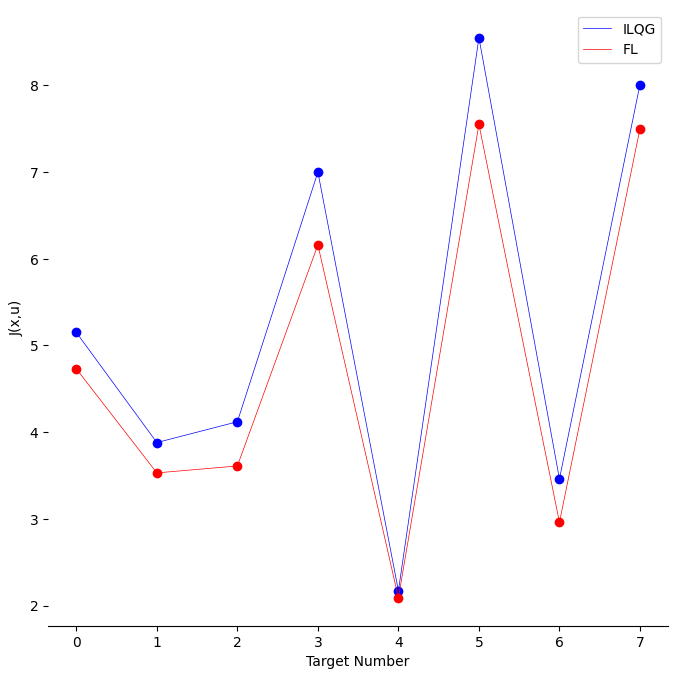

In [10]:
FLCOST = [4.73,3.53,3.61,6.16,2.09,7.55,2.96,7.5]
ILQGCOST = [5.15,3.88,4.12,7,2.17,8.55,3.46,8.01]

fig,ax = plt.subplots(figsize = (8,8))
ax.scatter(np.linspace(0,7,8),ILQGCOST,color = "blue")
ax.plot(np.linspace(0,7,8),ILQGCOST,color = "blue" ,label = "ILQG",linewidth = .5)
ax.scatter(np.linspace(0,7,8),FLCOST,color = "red")
ax.plot(np.linspace(0,7,8),FLCOST,color = "red" ,label = "FL",linewidth = .5)
plt.legend()
ax.set_xlabel("Target Number")
ax.set_ylabel("J(x,u)")
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

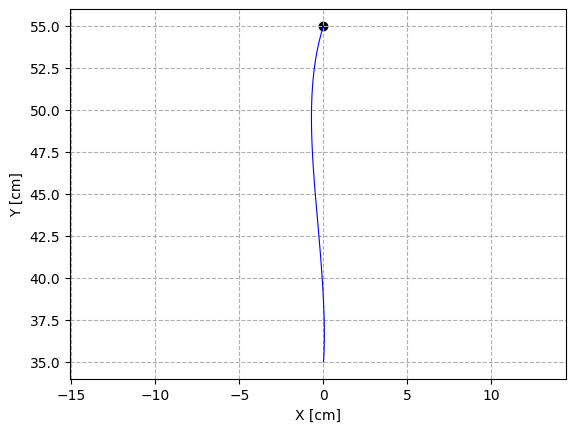

In [11]:
K = 60
Duration = .6
dt = Duration/K
w1 = 1e6
w2 = 1e4
r1 = 1e-3
d = 14.285
start = [0,35]
targets = [0,55]
xILQG,yILQG,uILQG = ILQG(Duration,w1,w2,r1,targets,K,start,plot = True)